Here you may get familiar with PU learning, play with mixtures of laplace and normal distributions, test DEDPUL and other methods.

The notebook is based on the paper "DEDPUL: Difference-of-Estimated-Densities-based Positive-Unlabeled Learning". 

NOTE that in the original paper proportions and posteriors of Positive class are presented and estimated, while methods in this notebook by default estimate those for Negative class. To convert, just substract the estimates from 1.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, laplace
import random

from sklearn.metrics import accuracy_score, log_loss, mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score, brier_score_loss, f1_score

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
from IPython import display

from algorithms import *
from utils import *
from KMPE import *
from NN_functions import *

import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: F

# What is PU learning?

Positive-Unlabeled (PU) Classification is a problem of semi-supervised learning on the data that is corrupted in a specific way. Unlike supervised binary classification, PU classification does not require labeled samples from both classes for training. Instead, two samples are required: a labeled sample from Positive (P) class, and an Unlabeled (U) sample with mixed data from both Positive (P) and Negative (N) classes with generally unknown mixing proportions. The objectives are: (i) to estimate the proportions of P and N in U and (ii) to classify it, i.e. to assign probability of being P rather than N for each instance in U. The first problem is reffered to as Mixture Proportions Estimation; the second - as PU Classification.

Several methods that solve these problems are highlighted in this notebook.

# Data

In [2]:
# specify distributions to sample data from.

# mode = 'normal'
mode ='laplace'

In [3]:
# feel free to play with parameters of distributions;
# initially we recommend to stick to cases of s1=s2

# centers and standard deviations of P and N distributions
mu1 = 0
s1 = 1
mu2 = 4
s2 = 1

# alpha is proportion of N in U; (1 - alpha) is proportion of P in U; these will be unknown for methods below;
# note that not alpha but alpha^* (computed below) is the proportion that the methods are supposed to identify 
# (find out why in the paper)
alpha = 0.75

if mode == 'normal':
    p1 = lambda x: norm.pdf(x, mu1, s1)
    p2 = lambda x: norm.pdf(x, mu2, s2)
    pm = lambda x: p1(x) * (1 - alpha) + p2(x) * alpha
elif mode == 'laplace':
    p1 = lambda x: laplace.pdf(x, mu1, s1)
    p2 = lambda x: laplace.pdf(x, mu2, s2)
    pm = lambda x: p1(x) * (1 - alpha) + p2(x) * alpha

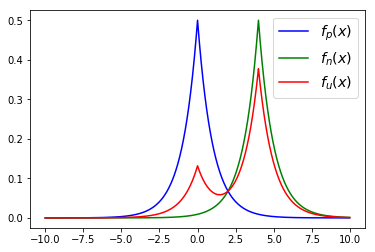

In [5]:
# These are the distributions.

plt.plot([x/100 for x in range(-1000, 1000)], [p1(x/100) for x in range(-1000, 1000)], 'b')
plt.plot([x/100 for x in range(-1000, 1000)], [p2(x/100) for x in range(-1000, 1000)], 'g')
plt.plot([x/100 for x in range(-1000, 1000)], [pm(x/100) for x in range(-1000, 1000)], 'r')

plt.legend(handles=(Line2D([], [], linestyle='-', color='b'),
                        Line2D([], [], linestyle='-', color='g'),
                        Line2D([], [], linestyle='-', color='r')),
               labels=('$f_p(x)$', '$f_n(x)$', '$f_u(x)$'),
          fontsize='x-large')

Lets generate samples from the Positive and the Unlabeled distributions $f_p(x)$ and $f_u(x)$. Remember, we don't have Negative data from $f_n(x)$.

In [6]:
if mode == 'normal':
    sampler = np.random.normal
elif mode == 'laplace':
    sampler = np.random.laplace

In [9]:
mix_size =10000
pos_size = 1000

mix_data_test = np.append(sampler(mu1, s1, int(mix_size * (1 - alpha))), 
                          sampler(mu2, s2, int(mix_size * alpha)))
pos_data_test = sampler(mu1, s1, int(pos_size))

data_test = np.append(mix_data_test, pos_data_test).reshape((-1, 1))
target_test = np.append(np.array([1] * mix_size), np.array([0] * pos_size))
target_test_true = np.append(np.array([0] * int(mix_size * (1 - alpha))), np.array([1] * int(mix_size * alpha)))
target_test_true = np.append(target_test_true, np.array([2] * pos_size))

mix_data_test = mix_data_test.reshape([-1, 1])
pos_data_test = pos_data_test.reshape([-1, 1])

data_test = np.concatenate((data_test, target_test.reshape(-1, 1), target_test_true.reshape(-1, 1)), axis=1)
np.random.shuffle(data_test)
target_test = data_test[:, 1]
target_test_true = data_test[:, 2]
data_test = data_test[:, 0].reshape(-1, 1)

In [10]:
# here we may estimate ground truth alpha^* for limited number of cases: 
# laplace and normal distributions where either mean or std coincide.
# alpha^* is the desired proportion that the methods are supposed to identify.

cons_alpha = estimate_cons_alpha(mu2 - mu1, s2 / s1, alpha, mode)
print('alpha* =', cons_alpha)

alpha* = 0.7362632708334493


Below several methods are applied to solve MPE and PU Classification

# DEDPUL

The short way:

In [33]:
test_alpha, poster = estimate_poster_cv(data_test, target_test, estimator='dedpul', alpha=None,
                                         estimate_poster_options={'disp': False},
                                         estimate_diff_options={},
                                         estimate_preds_cv_options={'bn': False, 'l2': 1e-4,
                                             'cv': 5, 'n_networks': 1, 'lr': 1e-3, 'hid_dim': 16, 'n_hid_layers': 0,
                                         },
                                         train_nn_options={
                                             'n_epochs': 200, 'batch_size': 64,
                                             'n_batches': None, 'n_early_stop': 10, 'disp': True,
                                        }
                                       )

print('alpha:', test_alpha, '\nerror:', abs(test_alpha - cons_alpha))

epoch 0 , train_loss= 0.5815 , test_loss= 0.56829
epoch 1 , train_loss= 0.56383 , test_loss= 0.55201
epoch 2 , train_loss= 0.56183 , test_loss= 0.53919
epoch 3 , train_loss= 0.53184 , test_loss= 0.52806
epoch 4 , train_loss= 0.52981 , test_loss= 0.51808
epoch 5 , train_loss= 0.52157 , test_loss= 0.50963
epoch 6 , train_loss= 0.52177 , test_loss= 0.50122
epoch 7 , train_loss= 0.52246 , test_loss= 0.49456
epoch 8 , train_loss= 0.50648 , test_loss= 0.4879
epoch 9 , train_loss= 0.49586 , test_loss= 0.48117
epoch 10 , train_loss= 0.47951 , test_loss= 0.47518
epoch 11 , train_loss= 0.48195 , test_loss= 0.47058
epoch 12 , train_loss= 0.48092 , test_loss= 0.46603
epoch 13 , train_loss= 0.46418 , test_loss= 0.46078
epoch 14 , train_loss= 0.45951 , test_loss= 0.45648
epoch 15 , train_loss= 0.46237 , test_loss= 0.45317
epoch 16 , train_loss= 0.4527 , test_loss= 0.45018
epoch 17 , train_loss= 0.48137 , test_loss= 0.44895
epoch 18 , train_loss= 0.45267 , test_loss= 0.44585
epoch 19 , train_loss= 0.

epoch 28 , train_loss= 0.44412 , test_loss= 0.45231
epoch 29 , train_loss= 0.45932 , test_loss= 0.45083
epoch 30 , train_loss= 0.45608 , test_loss= 0.44919
epoch 31 , train_loss= 0.47016 , test_loss= 0.44768
epoch 32 , train_loss= 0.44844 , test_loss= 0.4463
epoch 33 , train_loss= 0.45815 , test_loss= 0.44509
epoch 34 , train_loss= 0.43461 , test_loss= 0.44394
epoch 35 , train_loss= 0.43532 , test_loss= 0.44278
epoch 36 , train_loss= 0.43954 , test_loss= 0.44169
epoch 37 , train_loss= 0.43901 , test_loss= 0.44063
epoch 38 , train_loss= 0.44988 , test_loss= 0.43939
epoch 39 , train_loss= 0.43624 , test_loss= 0.43822
epoch 40 , train_loss= 0.44266 , test_loss= 0.43735
epoch 41 , train_loss= 0.42672 , test_loss= 0.4366
epoch 42 , train_loss= 0.44738 , test_loss= 0.43581
epoch 43 , train_loss= 0.41444 , test_loss= 0.43513
epoch 44 , train_loss= 0.45812 , test_loss= 0.43446
epoch 45 , train_loss= 0.42445 , test_loss= 0.43373
epoch 46 , train_loss= 0.43005 , test_loss= 0.43308
epoch 47 , tra

epoch 57 , train_loss= 0.40896 , test_loss= 0.42725
epoch 58 , train_loss= 0.4227 , test_loss= 0.42677
epoch 59 , train_loss= 0.41366 , test_loss= 0.42656
epoch 60 , train_loss= 0.42469 , test_loss= 0.42635
epoch 61 , train_loss= 0.45625 , test_loss= 0.42592
epoch 62 , train_loss= 0.41851 , test_loss= 0.42563
epoch 63 , train_loss= 0.44246 , test_loss= 0.42532
epoch 64 , train_loss= 0.40507 , test_loss= 0.42561
epoch 65 , train_loss= 0.41833 , test_loss= 0.42591
epoch 66 , train_loss= 0.43345 , test_loss= 0.42611
epoch 67 , train_loss= 0.41664 , test_loss= 0.42585
epoch 68 , train_loss= 0.43891 , test_loss= 0.42564
epoch 69 , train_loss= 0.44461 , test_loss= 0.425
epoch 70 , train_loss= 0.43218 , test_loss= 0.42479
epoch 71 , train_loss= 0.42065 , test_loss= 0.42515
epoch 72 , train_loss= 0.43645 , test_loss= 0.42483
epoch 73 , train_loss= 0.4182 , test_loss= 0.42487
epoch 74 , train_loss= 0.41741 , test_loss= 0.42523
epoch 75 , train_loss= 0.41621 , test_loss= 0.42558
epoch 76 , train

The short-but-a-bit-longer way:

In [35]:
# estimate y(x), the predictions of NTC

preds = estimate_preds_cv(data_test, target_test, cv=5, n_networks=1, lr=1e-3, hid_dim=16, n_hid_layers=0, l2=1e-4,
                          bn=False,
                          train_nn_options={'n_epochs': 200, 'batch_size': 64,
                                            'n_batches': None, 'n_early_stop': 10, 'disp': True})

print('ac', accuracy_score(target_test, preds.round()))
print('roc', roc_auc_score(target_test, preds))

epoch 0 , train_loss= 0.49636 , test_loss= 0.46487
epoch 1 , train_loss= 0.49241 , test_loss= 0.45682
epoch 2 , train_loss= 0.49088 , test_loss= 0.44949
epoch 3 , train_loss= 0.4789 , test_loss= 0.44399
epoch 4 , train_loss= 0.45345 , test_loss= 0.43773
epoch 5 , train_loss= 0.45139 , test_loss= 0.43165
epoch 6 , train_loss= 0.46316 , test_loss= 0.42655
epoch 7 , train_loss= 0.47189 , test_loss= 0.42274
epoch 8 , train_loss= 0.44566 , test_loss= 0.41935
epoch 9 , train_loss= 0.44914 , test_loss= 0.41625
epoch 10 , train_loss= 0.45237 , test_loss= 0.41303
epoch 11 , train_loss= 0.46722 , test_loss= 0.41086
epoch 12 , train_loss= 0.44591 , test_loss= 0.40918
epoch 13 , train_loss= 0.44367 , test_loss= 0.40737
epoch 14 , train_loss= 0.44142 , test_loss= 0.40478
epoch 15 , train_loss= 0.43507 , test_loss= 0.40231
epoch 16 , train_loss= 0.44508 , test_loss= 0.40023
epoch 17 , train_loss= 0.44517 , test_loss= 0.39929
epoch 18 , train_loss= 0.44522 , test_loss= 0.39885
epoch 19 , train_loss= 

epoch 62 , train_loss= 0.43031 , test_loss= 0.43819
epoch 63 , train_loss= 0.43869 , test_loss= 0.43806
epoch 64 , train_loss= 0.42951 , test_loss= 0.43804
epoch 65 , train_loss= 0.40884 , test_loss= 0.43792
epoch 66 , train_loss= 0.43112 , test_loss= 0.43775
epoch 67 , train_loss= 0.42177 , test_loss= 0.4377
epoch 68 , train_loss= 0.41553 , test_loss= 0.43772
epoch 69 , train_loss= 0.42453 , test_loss= 0.43753
epoch 70 , train_loss= 0.4458 , test_loss= 0.43738
epoch 71 , train_loss= 0.41987 , test_loss= 0.43722
epoch 72 , train_loss= 0.43272 , test_loss= 0.43716
epoch 73 , train_loss= 0.4311 , test_loss= 0.43697
epoch 74 , train_loss= 0.43275 , test_loss= 0.43683
epoch 75 , train_loss= 0.40987 , test_loss= 0.43675
epoch 76 , train_loss= 0.40928 , test_loss= 0.43674
epoch 77 , train_loss= 0.42818 , test_loss= 0.43676
epoch 78 , train_loss= 0.42156 , test_loss= 0.43676
epoch 79 , train_loss= 0.42087 , test_loss= 0.43679
epoch 80 , train_loss= 0.41562 , test_loss= 0.43683
epoch 81 , trai

epoch 10 , train_loss= 0.50474 , test_loss= 0.49431
epoch 11 , train_loss= 0.49734 , test_loss= 0.48796
epoch 12 , train_loss= 0.46781 , test_loss= 0.48194
epoch 13 , train_loss= 0.47054 , test_loss= 0.47639
epoch 14 , train_loss= 0.46607 , test_loss= 0.47138
epoch 15 , train_loss= 0.48708 , test_loss= 0.46684
epoch 16 , train_loss= 0.47279 , test_loss= 0.46299
epoch 17 , train_loss= 0.43265 , test_loss= 0.45884
epoch 18 , train_loss= 0.45627 , test_loss= 0.45505
epoch 19 , train_loss= 0.44732 , test_loss= 0.45184
epoch 20 , train_loss= 0.43546 , test_loss= 0.4491
epoch 21 , train_loss= 0.42142 , test_loss= 0.44671
epoch 22 , train_loss= 0.43089 , test_loss= 0.4444
epoch 23 , train_loss= 0.45418 , test_loss= 0.44259
epoch 24 , train_loss= 0.42985 , test_loss= 0.44067
epoch 25 , train_loss= 0.43691 , test_loss= 0.43835
epoch 26 , train_loss= 0.42641 , test_loss= 0.43664
epoch 27 , train_loss= 0.42248 , test_loss= 0.43532
epoch 28 , train_loss= 0.42955 , test_loss= 0.43414
epoch 29 , tra

In [36]:
bw_mix = 0.05
bw_pos = 0.1
threshold = (preds[target_test==1].mean()+preds[target_test==0].mean()) / 2
k_neighbours = int(preds[target_test==1].shape[0] // 20)

In [37]:
# estimate density ratio g_p(y)/g_u(y) with tuned bandwidths, apply heuristics

diff = estimate_diff(preds, target_test,
                     bw_mix, bw_pos, 'logit', threshold, k_neighbours, MT=False)

In [38]:
# plt.plot(preds[target_test==1], diff, 'bo')

In [39]:
# Estimate priors alpha^* and posteriors p_p^*(x) with EM algorithm (if converges) 
# or with alternative max_slope otherwise

test_alpha, poster = estimate_poster_em(diff, mode='dedpul', converge=True, nonconverge=True, 
                                        max_diff=0.05, step=0.0025, alpha_as_mean_poster=True)#, alpha=cons_alpha)
print('alpha:', test_alpha, '\nmean_poster:', np.mean(poster), '\ncons_alpha:', cons_alpha)

alpha: 0.7335942547925534 
mean_poster: 0.7335994367271413 
cons_alpha: 0.7362632708334493


Text(0.5,0,'$y(x)$')

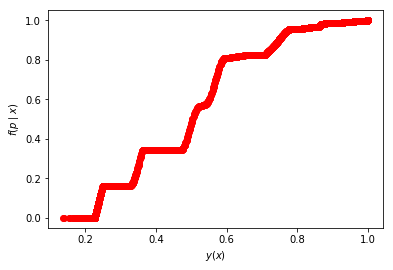

In [40]:
plt.plot(preds[target_test==1], poster, 'ro')
plt.ylabel('$f(p \mid x)$')
plt.xlabel('$y(x)$')

Analyze results:

In [41]:
# compute performance measures

realistic_poster = np.apply_along_axis(lambda x: (pm(x) - p1(x) * (1 - cons_alpha)) / pm(x), -1, 
                    data_test[target_test_true != 2].reshape(-1,))
realistic_poster[realistic_poster < 0] = 0

print('accuracy:', 
      accuracy_score(target_test_true[target_test_true != 2], poster.round()))
print('ROC-AUC:',
      roc_auc_score(target_test_true[target_test_true != 2], poster))
print('brier:',
      brier_score_loss(target_test_true[target_test_true != 2], poster))
print('true MAE:',
      mean_absolute_error(realistic_poster, poster))
print('true RMSE:',
      np.sqrt(mean_squared_error(realistic_poster, poster)))

accuracy: 0.9396
ROC-AUC: 0.9697143199999999
brier: 0.04836416412997892
true MAE: 0.014067348456436844
true RMSE: 0.032735075991237


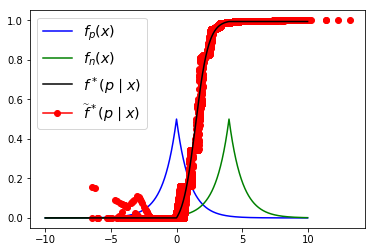

In [42]:
# illustrate performance graphically. The closer red circles to black line - the better.

plt.plot([x/100 for x in range(-1000, 1000)], [p1(x/100) for x in range(-1000, 1000)], 'b')
plt.plot([x/100 for x in range(-1000, 1000)], [p2(x/100) for x in range(-1000, 1000)], 'g')
plt.plot(data_test[target_test_true != 2], poster, 'ro')
plt.plot([x/100 for x in range(-1000, 1000)], [max((pm(x/100) - p1(x/100) * (1 - cons_alpha)) / pm(x/100), 0)
                                               for x in range(-1000, 1000)], 'k')

plt.legend(handles=(Line2D([], [], linestyle='-', color='b'),
                        Line2D([], [], linestyle='-', color='g'),
                        Line2D([], [], linestyle='-', color='k'),
                        Line2D([], [], color='r', marker='o')),
               labels=('$f_p(x)$', '$f_n(x)$', '$f^*(p \mid x)$', '$\widetilde{f}^*(p \mid x)$'),
          fontsize='x-large')

In [24]:
# # illustrate max_slope: argument of the highest point on the second graph is the estimate \alpha_n^*

# posters = []
# step = 0.005
# for test_alpha_ in np.arange(0, 1+step, step):
#     poster_ = 1 - diff * (1 - test_alpha_)
#     poster_[poster_ < 0] = 0
#     posters.append(np.mean(poster_) - test_alpha_)


# fig, axs = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(6, 10))
# axs[0].plot(np.arange(0, 1+step, step), posters)
# axs[1].plot(np.arange(2*step, 1+step, step), np.diff(np.diff(posters)))

# Other methods

# EN

EN is a common baseline to compare with.

Paper: https://cseweb.ucsd.edu/~elkan/posonly.pdf

In [31]:
EN_alpha, EN_poster = estimate_poster_en(preds, target_test, alpha=None, estimator='e3')

print('EN priors =', EN_alpha)
print('EN posters mean =', np.mean(EN_poster))
print()

EN_realistic_poster = np.apply_along_axis(lambda x: (pm(x) - p1(x) * (1 - cons_alpha)) / pm(x), -1, 
                        data_test[target_test_true != 2].reshape(-1, ))

print('accuracy:', 
      accuracy_score(target_test_true[target_test_true != 2], EN_poster.round()))
print('ROC-AUC:',
      roc_auc_score(target_test_true[target_test_true != 2], EN_poster))
print('brier:',
      brier_score_loss(target_test_true[target_test_true != 2], EN_poster.round()))
print('MAE:',
      mean_absolute_error(EN_realistic_poster, EN_poster))
print('RMSE:',
      np.sqrt(mean_squared_error(EN_realistic_poster, EN_poster)))

EN priors = 0.7772898191028789
EN posters mean = 0.7822318219333996

accuracy: 0.9288
ROC-AUC: 0.9701842399999999
brier: 0.0712
MAE: 0.05460541901232714
RMSE: 0.11013102749541907


(0, 1)

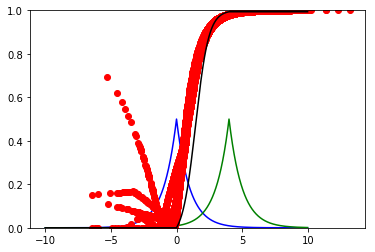

In [32]:
plt.plot([x/100 for x in range(-1000, 1000)], [p1(x/100) for x in range(-1000, 1000)], 'b')
plt.plot([x/100 for x in range(-1000, 1000)], [p2(x/100) for x in range(-1000, 1000)], 'g')
plt.plot(data_test[target_test_true != 2], EN_poster, 'ro')
plt.plot([x/100 for x in range(-1000, 1000)], [max((pm(x/100) - p1(x/100) * (1 - cons_alpha)) / pm(x/100), 0) 
                                               for x in range(-1000, 1000)], 'k')
plt.ylim(0, 1)

# nnPU

nnPU is considered state-of-the-art (before DEDPUL). The method cannot identify the mixing proportions alpha and recquires them as a parameter. The method trains a neural network on unbiased risk function.

Paper: https://papers.nips.cc/paper/6765-positive-unlabeled-learning-with-non-negative-risk-estimator.pdf

In [44]:
nnre_poster = estimate_preds_cv(data_test, target_test, n_networks=1, cv=5, training_mode='nnre', alpha=cons_alpha,
                                n_hid_layers=0, lr=1e-3, bn=False, l2=1e-4,
                                train_nn_options={
                                    'n_epochs': 200, 'batch_size': 64, 'loss_function': 'sigmoid',
                                    'n_batches': None, 'n_early_stop': 20, 'disp': True})[target_test == 1]


nnre_realistic_poster = np.apply_along_axis(lambda x: (pm(x) - p1(x) * (1 - cons_alpha)) / pm(x), -1, 
                        data_test[target_test_true != 2].reshape(-1, ))

print('accuracy:', 
      accuracy_score(target_test_true[target_test_true != 2], nnre_poster.round()))
print('ROC-AUC:',
      roc_auc_score(target_test_true[target_test_true != 2], nnre_poster))
print('brier:',
      brier_score_loss(target_test_true[target_test_true != 2], nnre_poster.round()))
print('MAE:',
      mean_absolute_error(nnre_realistic_poster, nnre_poster))
print('RMSE:',
      np.sqrt(mean_squared_error(nnre_realistic_poster, nnre_poster)))

epoch 0 , train_loss= 0.44897 , test_loss= 0.16883
epoch 1 , train_loss= 0.36103 , test_loss= 0.12806
epoch 2 , train_loss= 0.30033 , test_loss= 0.11052
epoch 3 , train_loss= 0.26837 , test_loss= 0.1035
epoch 4 , train_loss= 0.23493 , test_loss= 0.09996
epoch 5 , train_loss= 0.20226 , test_loss= 0.09748
epoch 6 , train_loss= 0.18849 , test_loss= 0.09514
epoch 7 , train_loss= 0.16983 , test_loss= 0.09322
epoch 8 , train_loss= 0.17286 , test_loss= 0.09117
epoch 9 , train_loss= 0.17244 , test_loss= 0.08881
epoch 10 , train_loss= 0.18089 , test_loss= 0.08664
epoch 11 , train_loss= 0.12042 , test_loss= 0.08452
epoch 12 , train_loss= 0.12574 , test_loss= 0.08245
epoch 13 , train_loss= 0.11152 , test_loss= 0.08041
epoch 14 , train_loss= 0.13975 , test_loss= 0.07864
epoch 15 , train_loss= 0.12094 , test_loss= 0.07689
epoch 16 , train_loss= 0.12804 , test_loss= 0.07517
epoch 17 , train_loss= 0.11738 , test_loss= 0.07334
epoch 18 , train_loss= 0.10724 , test_loss= 0.07158
epoch 19 , train_loss= 

epoch 78 , train_loss= 0.09914 , test_loss= 0.05158
epoch 79 , train_loss= 0.07253 , test_loss= 0.05162
epoch 80 , train_loss= 0.09805 , test_loss= 0.05132
epoch 81 , train_loss= 0.07336 , test_loss= 0.05105
epoch 82 , train_loss= 0.05498 , test_loss= 0.05053
epoch 83 , train_loss= 0.07568 , test_loss= 0.05024
epoch 84 , train_loss= 0.05488 , test_loss= 0.05024
epoch 85 , train_loss= 0.08202 , test_loss= 0.05005
epoch 86 , train_loss= 0.07239 , test_loss= 0.04951
epoch 87 , train_loss= 0.07612 , test_loss= 0.04917
epoch 88 , train_loss= 0.04424 , test_loss= 0.04918
epoch 89 , train_loss= 0.05451 , test_loss= 0.04927
epoch 90 , train_loss= 0.05945 , test_loss= 0.04913
epoch 91 , train_loss= 0.09728 , test_loss= 0.04908
epoch 92 , train_loss= 0.08148 , test_loss= 0.0493
epoch 93 , train_loss= 0.06592 , test_loss= 0.04927
epoch 94 , train_loss= 0.08737 , test_loss= 0.04919
epoch 95 , train_loss= 0.07447 , test_loss= 0.04903
epoch 96 , train_loss= 0.07529 , test_loss= 0.04906
epoch 97 , tr

epoch 112 , train_loss= 0.08527 , test_loss= 0.03143
epoch 113 , train_loss= 0.06529 , test_loss= 0.03143
epoch 114 , train_loss= 0.07838 , test_loss= 0.03141
epoch 115 , train_loss= 0.04732 , test_loss= 0.03138
epoch 116 , train_loss= 0.0582 , test_loss= 0.03135
epoch 0 , train_loss= 0.28709 , test_loss= 0.11929
epoch 1 , train_loss= 0.25184 , test_loss= 0.11354
epoch 2 , train_loss= 0.22439 , test_loss= 0.11021
epoch 3 , train_loss= 0.21873 , test_loss= 0.10725
epoch 4 , train_loss= 0.2056 , test_loss= 0.10393
epoch 5 , train_loss= 0.20155 , test_loss= 0.10041
epoch 6 , train_loss= 0.11949 , test_loss= 0.09668
epoch 7 , train_loss= 0.16641 , test_loss= 0.09276
epoch 8 , train_loss= 0.16499 , test_loss= 0.08862
epoch 9 , train_loss= 0.12952 , test_loss= 0.08523
epoch 10 , train_loss= 0.13804 , test_loss= 0.08207
epoch 11 , train_loss= 0.11256 , test_loss= 0.07856
epoch 12 , train_loss= 0.13244 , test_loss= 0.07509
epoch 13 , train_loss= 0.10546 , test_loss= 0.07177
epoch 14 , train_lo

(0, 1)

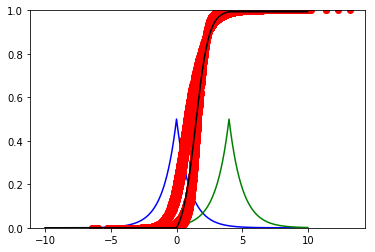

In [45]:
plt.plot([x/100 for x in range(-1000, 1000)], [p1(x/100) for x in range(-1000, 1000)], 'b')
plt.plot([x/100 for x in range(-1000, 1000)], [p2(x/100) for x in range(-1000, 1000)], 'g')
plt.plot(data_test[target_test_true != 2].flatten(), nnre_poster, 'ro')
plt.plot([x/100 for x in range(-1000, 1000)], [max((pm(x/100) - p1(x/100) * (1 - cons_alpha)) / pm(x/100), 0) 
                                               for x in range(-1000, 1000)], 'k')
plt.ylim(0, 1)

# Proportions Estimation

KM and TIcE are considered state-of-the-art in Mixture Proportion Estimation (before DEDPUL).

# KM 

Implementation is taken from http://web.eecs.umich.edu/~cscott/code.html#kmpe

Paper: https://arxiv.org/pdf/1603.02501.pdf

In [22]:
### KM is a very slow method

# KM_1, KM_2 = wrapper(mix_data_test, pos_data_test, epsilon=0.04, lambda_lower_bound=0.5, lambda_upper_bound=10, 
#                      KM_1=True, KM_2=True)
# KM_1 = 1 - KM_1
# KM_2 = 1 - KM_2

# print(KM_1)
# print(KM_2)
# print('KM_1:', KM_1, '\nKM_2:', KM_2, '\ncons_alpha:', cons_alpha, 
#       '\nerror KM_1:', abs(cons_alpha - KM_1), '\nerror KM_2:', abs(cons_alpha - KM_2))

# TIcE

Implementation is taken from https://dtai.cs.kuleuven.be/software/tice

Paper: https://www.aaai.org/ocs/index.php/AAAI/AAAI18/paper/viewFile/16776/16539

In [53]:
from TIcE import tice_wrapper

In [54]:
tice_alpha = tice_wrapper(data_test, target_test, k=10, n_folds=10, delta=0.2, n_splits=40)
print('tice_alpha:', tice_alpha, '\ncons_alpha:', cons_alpha, '\nerror:', abs(cons_alpha - tice_alpha))

tice_alpha: 0.7169769849383337 
cons_alpha: 0.7362632708334493 
error: 0.019286285895115607
